In [1]:
import random
import logging
import numpy as np
import torch
import csv
from tqdm import tqdm
from pytorchfi import core
from finetune import Ground_truth_model
from errors import stuck_at_one, stuck_at_zero, bit_flip
import bitflips
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from modified_fi import ModifiedFaultInjection

In [ ]:
class Perturbed_model:
    def __init__(self,model_,tokenizer,batch_size,input_shape,layer_types,use_cuda=False):
        self.ground_truth=model_
        self.inj_model=ModifiedFaultInjection(
            model=model_.model,
            batch_size=batch_size,
            input_shape=input_shape,
            layer_types=layer_types,
            use_cuda=use_cuda
        )
        self.tokenizer=tokenizer
    def setup(self):
        self.inj_model._traverse_model_set_hooks()
        print(self.inj_model.print_pytorchfi_layer_summary)
    def experiment(self,test_loader,n=10):
        accuracies=[]
        for i in tqdm(range(n)):
           
            corrupted_model = bitflips.random_inj_per_layer_batched(self.inj_model)
                
            print("Finished injection, beginning evaluation.")
            # Evaluate the faulty model
            accuracy = self.evaluate(corrupted_model, test_loader)
            print("Finished evaluation.")
            accuracies.append(accuracy)
                
                # Reset the fault injection for the next iteration
            self.inj_model.fi_reset()

        # Visualize the accuracy results
        plt.plot(range(n), accuracies, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Under Fault Injections')
        plt.show()
    def evaluate(self, model, dataloader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print("Model on device.")
        model.eval()
        print("Placed in eval mode.")

        total, correct = 0, 0
        print("Beginning Evaluation.")
        with torch.no_grad():
            for batch in dataloader:

                input_ids, attention_mask, labels = (t.to(device) for t in batch)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                self.inj_model.reset_current_layer()


        accuracy = 100 * correct / total
        return accuracy


In [3]:
class IMDbDataset(Dataset):
    def __init__(self, tokenizer, split="train", max_length=128):
        self.dataset = load_dataset("imdb", split=split)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]["text"]
        label = self.dataset[idx]["label"]
        inputs = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )
        return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0), torch.tensor(label)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load("rnn_model.pt", weights_only=True))
ground_truth = Ground_truth_model(model,tokenizer)


train_dataset = IMDbDataset(ground_truth.tokenizer, split="train[:5000]")  
test_dataset = IMDbDataset(ground_truth.tokenizer, split="test[:992]")    


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

accuracy=ground_truth.evaluate(test_dataloader)
print(f"Initial accuracy on IMDb test set: {accuracy:.2f}%")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initial accuracy on IMDb test set: 100.00%


In [5]:
print(ground_truth.model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
class WrappedBERT(torch.nn.Module):
    def __init__(self, model):
        super(WrappedBERT, self).__init__()
        self.model = model

    def forward(self, input_ids):
        attention_mask = (input_ids != 0).long()  # Assume padding token ID is 0
        return self.model(input_ids=input_ids, attention_mask=attention_mask)
    
wrapped_bert = WrappedBERT(ground_truth.model)

In [7]:
perturb_model = Perturbed_model(wrapped_bert,ground_truth.tokenizer,batch_size=16, input_shape=[128],layer_types=[torch.nn.Linear])
# print(len(perturb_model.inj_model.layers_dim))
# print(perturb_model.inj_model.corrupt_layer)
# print(perturb_model.inj_model.print_pytorchfi_layer_summary())
# perturb_model.experiment(test_dataloader)

In [8]:
print(len(perturb_model.inj_model.output_size))


38


 80%|████████  | 8/10 [01:48<00:27, 13.59s/it]

Finished evaluation.
Injecting into layer 0, neuron index 10
Injecting into layer 1, neuron index 36
Injecting into layer 2, neuron index 113
Injecting into layer 3, neuron index 61
Injecting into layer 4, neuron index 72
Injecting into layer 5, neuron index 98
Injecting into layer 6, neuron index 71
Injecting into layer 7, neuron index 116
Injecting into layer 8, neuron index 97
Injecting into layer 9, neuron index 61
Injecting into layer 10, neuron index 83
Injecting into layer 11, neuron index 47
Injecting into layer 12, neuron index 88
Injecting into layer 13, neuron index 100
Injecting into layer 14, neuron index 102
Injecting into layer 15, neuron index 43
Injecting into layer 16, neuron index 90
Injecting into layer 17, neuron index 22
Injecting into layer 18, neuron index 122
Injecting into layer 19, neuron index 26
Injecting into layer 20, neuron index 38
Injecting into layer 21, neuron index 25
Injecting into layer 22, neuron index 0
Injecting into layer 23, neuron index 4
In

 90%|█████████ | 9/10 [02:01<00:13, 13.57s/it]

Finished evaluation.
Injecting into layer 0, neuron index 36
Injecting into layer 1, neuron index 70
Injecting into layer 2, neuron index 101
Injecting into layer 3, neuron index 55
Injecting into layer 4, neuron index 19
Injecting into layer 5, neuron index 32
Injecting into layer 6, neuron index 13
Injecting into layer 7, neuron index 108
Injecting into layer 8, neuron index 11
Injecting into layer 9, neuron index 69
Injecting into layer 10, neuron index 44
Injecting into layer 11, neuron index 22
Injecting into layer 12, neuron index 5
Injecting into layer 13, neuron index 108
Injecting into layer 14, neuron index 55
Injecting into layer 15, neuron index 105
Injecting into layer 16, neuron index 93
Injecting into layer 17, neuron index 85
Injecting into layer 18, neuron index 33
Injecting into layer 19, neuron index 1
Injecting into layer 20, neuron index 52
Injecting into layer 21, neuron index 34
Injecting into layer 22, neuron index 20
Injecting into layer 23, neuron index 101
In

100%|██████████| 10/10 [02:16<00:00, 13.62s/it]

Finished evaluation.


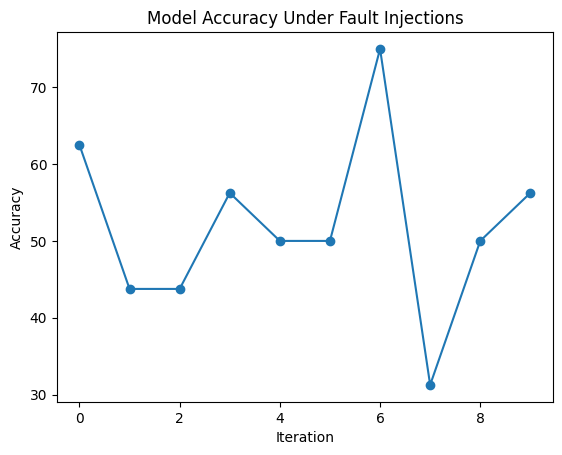

In [9]:
perturb_model.experiment(test_dataloader)

In [10]:
print(f"Number of injectable layers: {len(perturb_model.inj_model.layers_type)}")

Number of injectable layers: 38


In [11]:
print("Output size:", perturb_model.inj_model.output_size)

Output size: [[1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 768], [1, 2]]


In [12]:
print("Total batches:", perturb_model.inj_model.get_total_batches())

Total batches: 16


In [13]:
for batch in test_dataloader:
    print(batch[0].size())

torch.Size([16, 128])


torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size